In [1]:
# Import necessary libraries

import time
import random
import numpy as np
import copy
import json
from collections import Counter
from typing import Dict, Any, List, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gym
from gym import spaces
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback, ProgressBarCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy as PPOMlp
from baselines import logger

# Import Yawning Titan specific modules
from yawning_titan.envs.generic.core.blue_interface import BlueInterface
from yawning_titan.envs.generic.core.red_interface import RedInterface
from yawning_titan.envs.generic.generic_env import GenericNetworkEnv
from yawning_titan.envs.generic.core.action_loops import ActionLoop
from yawning_titan.envs.generic.core.network_interface import NetworkInterface
from yawning_titan.game_modes.game_mode import GameMode
from yawning_titan.networks.node import Node
from yawning_titan.networks.network import Network
from yawning_titan.envs.generic.core import reward_functions
from yawning_titan.envs.generic.helpers.eval_printout import EvalPrintout
from yawning_titan.envs.generic.helpers.graph2plot import CustomEnvGraph

# Import Reward Machine related modules
from reward_machines.reward_machine import RewardMachine
from reward_machines.rm_environment import RewardMachineEnv, RewardMachineWrapper
from reward_machines.reward_functions import ConstantRewardFunction
from reward_machines.reward_machine_utils import evaluate_dnf

/Users/michelafarruggia/yawning_titan/yt_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the game mode configuration from YAML file
game_mode = GameMode()
game_mode = game_mode.create_from_yaml(yaml='/Users/michelafarruggia/yawning_titan/game_mode_balanced.yaml', legacy=False, infer_legacy=True)
print(game_mode.game_rules.max_steps.value)

# Create a network representation
network = Network()

# Define network nodes and their positions

# External layer
router_1 = Node("Boundary router packet filter")
router_1.node_position = [0, 600]
network.add_node(router_1)

switch_1 = Node("External switch")
switch_1.node_position = [0, 500]
network.add_node(switch_1)

network_ids_1 = Node("Network IDS (DMZ)")
network_ids_1.node_position = [-200, 500]
network.add_node(network_ids_1)

dns_server_external = Node("DNS server esterno")
dns_server_external.node_position = [200, 500]
network.add_node(dns_server_external)

# DMZ layer
server_1 = Node("Main Firewall/VPN server/NAT")
server_1.node_position = [-100, 400]
network.add_node(server_1)

server_2 = Node("External Web Server/Host IDS")
server_2.node_position = [100, 400]
network.add_node(server_2)

switch_2 = Node("Internal Switch (DMZ)")
switch_2.node_position = [0, 300]
network.add_node(switch_2)

network_ids_2 = Node("Network IDS (DMZ Internal)")
network_ids_2.node_position = [-200, 300]
network.add_node(network_ids_2)

# Internal layer
internal_firewall = Node("Internal Firewall")
internal_firewall.node_position = [0, 200]
network.add_node(internal_firewall)

server_3 = Node("Database Server")
server_3.node_position = [200, 200]
network.add_node(server_3)

email_server = Node("Email Server/Host IDS")
email_server.node_position = [-200, 200]
network.add_node(email_server)

dns_server_internal = Node("DNS server interno")
dns_server_internal.node_position = [400, 200]
network.add_node(dns_server_internal)

web_proxy = Node("Web proxy server")
web_proxy.node_position = [-400, 200]
network.add_node(web_proxy)

switch_3 = Node("Internal Switch")
switch_3.node_position = [0, 100]
network.add_node(switch_3)

network_ids_3 = Node("Network IDS Internal")
network_ids_3.node_position = [-200, 100]
network.add_node(network_ids_3)

# Subnet layer
subnet1_router = Node("Router Subnet 1")
subnet1_router.node_position = [-300, 0]
network.add_node(subnet1_router)

subnet2_router = Node("Router Subnet 2")
subnet2_router.node_position = [-100, 0]
network.add_node(subnet2_router)

subnet3_router = Node("Router Subnet 3")
subnet3_router.node_position = [100, 0]
network.add_node(subnet3_router)

subnet4_router = Node("Router Subnet 4")
subnet4_router.node_position = [300, 0]
network.add_node(subnet4_router)

# Client/Server layer
client1_management = Node("Client1 Management")
client1_management.node_position = [-300, -100]
network.add_node(client1_management)

client1_hr = Node("Client1 HR")
client1_hr.node_position = [-100, -100]
network.add_node(client1_hr)

client1_it = Node("Client1 IT")
client1_it.node_position = [100, -100]
network.add_node(client1_it)

server_backup = Node("Server backup")
server_backup.node_position = [300, -100]
network.add_node(server_backup)

# Add edges to connect nodes
network.add_edge(router_1, switch_1)
network.add_edge(switch_1, server_1)
network.add_edge(switch_1, server_2)
network.add_edge(switch_1, network_ids_1)
network.add_edge(switch_1, dns_server_external)
network.add_edge(server_1, switch_2)
network.add_edge(switch_2, server_3)
network.add_edge(switch_2, internal_firewall)
network.add_edge(switch_2, email_server)
network.add_edge(switch_2, dns_server_internal)
network.add_edge(switch_2, web_proxy)
network.add_edge(switch_2, network_ids_2)
network.add_edge(internal_firewall, switch_3)
network.add_edge(switch_3, network_ids_3)
network.add_edge(switch_3, subnet1_router)
network.add_edge(switch_3, subnet2_router)
network.add_edge(switch_3, subnet3_router)
network.add_edge(switch_3, subnet4_router)
network.add_edge(subnet1_router, client1_management)
network.add_edge(subnet2_router, client1_hr)
network.add_edge(subnet3_router, client1_it)
network.add_edge(subnet4_router, server_backup)


# Set entry and high-value nodes
router_1.entry_node = True
server_3.high_value_node = True
server_backup.high_value_node = True
dns_server_internal.high_value_node = True
network_ids_3.high_value_node = True
network_ids_1.high_value_node = True
dns_server_external.high_value_node = True
server_1.high_value_node = True
server_2.high_value_node = True
network_ids_2.high_value_node = True

# Display the network details
network.show(verbose=True)

300
UUID                                  Name                           High Value Node    Entry Node      Vulnerability  Position (x,y)
------------------------------------  -----------------------------  -----------------  ------------  ---------------  ----------------
377feb91-ead3-433a-a09d-3907d76a9349  Boundary router packet filter  False              True                     0.01  0.00, 600.00
59a02e56-32db-4cff-bd1b-49c1902df70e  External switch                False              False                    0.01  0.00, 500.00
72b57197-805d-43d0-bec9-8ae8ae1ada11  Network IDS (DMZ)              True               False                    0.01  -200.00, 500.00
98027b16-92ce-4a5b-abce-c471826b2463  DNS server esterno             True               False                    0.01  200.00, 500.00
b24b9131-d82b-4e77-9775-92e5622317fb  Main Firewall/VPN server/NAT   True               False                    0.01  -100.00, 400.00
17259def-70c4-41c9-b49c-11c43e2ed804  External Web Server/

In [3]:
# Create NetworkInterface, RedInterface, and BlueInterface objects
network_interface = NetworkInterface(game_mode=game_mode, network=network)
red = RedInterface(network_interface)
blue = BlueInterface(network_interface)

In [4]:
YTenv = GenericNetworkEnv(
    red,
    blue,
    network_interface,
    print_metrics=True,
    show_metrics_every=10
)

2024-09-07 16:05:48,784::WARNING::py.warnings::_showwarnmsg::109::/Users/michelafarruggia/yawning_titan/yt_env/lib/python3.10/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))



In [5]:
env = Monitor(YTenv)

log_dir = "./logs_without_rm/"
env = Monitor(env, log_dir + "monitor.csv")

check_env(env, warn=True)

# reset anything changed during the check
_ = env.reset()

# Model's inizialization
model = PPO("MlpPolicy", env, verbose=1)

# Model's training
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env in a DummyVecEnv.
--Game over--
Total number of Games Played:  10
Stats over the last 10 games:
Average episode length:  10 

Blue Won    Red Won
----------  ---------
0           10
0.0%        100.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
isolate                      4  40.0%
connect                      3  30.0%
restore_node                 3  30.0%



--Game over--
Total number of Games Played:  20
Stats over the last 10 games:
Average episode length:  8 

Blue Won    Red Won
----------  ---------
0           10
0.0%        100.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
restore_node                 4  50.0%
isolate                      2  25.0%
connect                      2  25.0%
do_nothing                   0  0.0%



--Game over--
Total number of Games Played:  30
Stats over the las

--Game over--
Total number of Games Played:  190
Stats over the last 10 games:
Average episode length:  19 

Blue Won    Red Won
----------  ---------
0           10
0.0%        100.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
connect                      7  36.84%
isolate                      6  31.58%
restore_node                 6  31.58%
do_nothing                   0  0.0%
scan                         0  0.0%



--Game over--
Total number of Games Played:  200
Stats over the last 10 games:
Average episode length:  6 

Blue Won    Red Won
----------  ---------
0           10
0.0%        100.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
isolate                      2  40.0%
restore_node                 2  40.0%
connect                      1  20.0%
do_nothing                   0  0.0%



--Game over--
Total number of Games Pla

--Game over--
Total number of Games Played:  350
Stats over the last 10 games:
Average episode length:  56 

Blue Won    Red Won
----------  ---------
1           9
10.0%       90.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
isolate                     19  34.55%
restore_node                18  32.73%
connect                     17  30.91%
do_nothing                   1  1.82%
scan                         0  0.0%



--Game over--
Total number of Games Played:  360
Stats over the last 10 games:
Average episode length:  18 

Blue Won    Red Won
----------  ---------
0           10
0.0%        100.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
isolate                      7  41.18%
restore_node                 5  29.41%
connect                      5  29.41%
scan                         0  0.0%
do_nothing                   0  0.0%




--Game over--
Total number of Games Played:  490
Stats over the last 10 games:
Average episode length:  36 

Blue Won    Red Won
----------  ---------
1           9
10.0%       90.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
isolate                     12  34.29%
restore_node                11  31.43%
connect                     11  31.43%
do_nothing                   1  2.86%
scan                         0  0.0%



--Game over--
Total number of Games Played:  500
Stats over the last 10 games:
Average episode length:  67 

Blue Won    Red Won
----------  ---------
2           8
20.0%       80.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
isolate                     23  34.85%
restore_node                22  33.33%
connect                     18  27.27%
do_nothing                   2  3.03%
scan                         1  1.52%




--Game over--
Total number of Games Played:  590
Stats over the last 10 games:
Average episode length:  105 

Blue Won    Red Won
----------  ---------
2           8
20.0%       80.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
restore_node                38  35.85%
isolate                     35  33.02%
connect                     31  29.25%
scan                         1  0.94%
do_nothing                   1  0.94%



-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 95.4        |
|    ep_rew_mean          | 0.27        |
| time/                   |             |
|    fps                  | 608         |
|    iterations           | 10          |
|    time_elapsed         | 33          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.014721541 |
|    clip_fraction        | 0.175   

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 193         |
|    ep_rew_mean          | 0.6         |
| time/                   |             |
|    fps                  | 606         |
|    iterations           | 16          |
|    time_elapsed         | 54          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.013613381 |
|    clip_fraction        | 0.158       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.03       |
|    explained_variance   | -0.0952     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0654     |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.0357     |
|    value_loss           | 0.00774     |
-----------------------------------------
--Game over--
Total number of Games Played:  650
Stats over the last 10 games:
Average episode length:  271 

Blue Won

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 272         |
|    ep_rew_mean          | 0.9         |
| time/                   |             |
|    fps                  | 606         |
|    iterations           | 23          |
|    time_elapsed         | 77          |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.013103902 |
|    clip_fraction        | 0.162       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.87       |
|    explained_variance   | -0.0482     |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0503     |
|    n_updates            | 220         |
|    policy_gradient_loss | -0.0338     |
|    value_loss           | 0.00829     |
-----------------------------------------
--Game over--
Total number of Games Played:  700
Stats over the last 10 games:
Average episode length:  300 

Blue Won

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 297        |
|    ep_rew_mean          | 0.99       |
| time/                   |            |
|    fps                  | 607        |
|    iterations           | 30         |
|    time_elapsed         | 101        |
|    total_timesteps      | 61440      |
| train/                  |            |
|    approx_kl            | 0.01629122 |
|    clip_fraction        | 0.205      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.78      |
|    explained_variance   | 0.448      |
|    learning_rate        | 0.0003     |
|    loss                 | -0.0309    |
|    n_updates            | 290        |
|    policy_gradient_loss | -0.0389    |
|    value_loss           | 0.00532    |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 297         |
|    ep_rew_m

--Game over--
Total number of Games Played:  790
Stats over the last 10 games:
Average episode length:  300 

Blue Won    Red Won
----------  ---------
10          0
100.0%      0.0%


Action          Avg Times Used  Percentage of Action Usage
------------  ----------------  ----------------------------
isolate                    133  44.33%
restore_node                83  27.67%
connect                     75  25.0%
do_nothing                   5  1.67%
scan                         4  1.33%



------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 296          |
|    ep_rew_mean          | 0.98         |
| time/                   |              |
|    fps                  | 603          |
|    iterations           | 38           |
|    time_elapsed         | 128          |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0146895945 |
|    clip_fraction        |

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 290         |
|    ep_rew_mean          | 0.95        |
| time/                   |             |
|    fps                  | 601         |
|    iterations           | 45          |
|    time_elapsed         | 153         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.015102957 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.45       |
|    explained_variance   | 0.12        |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0699     |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.0301     |
|    value_loss           | 0.00862     |
-----------------------------------------
--Game over--
Total number of Games Played:  850
Stats over the last 10 games:
Average episode length:  300 

Blue Won

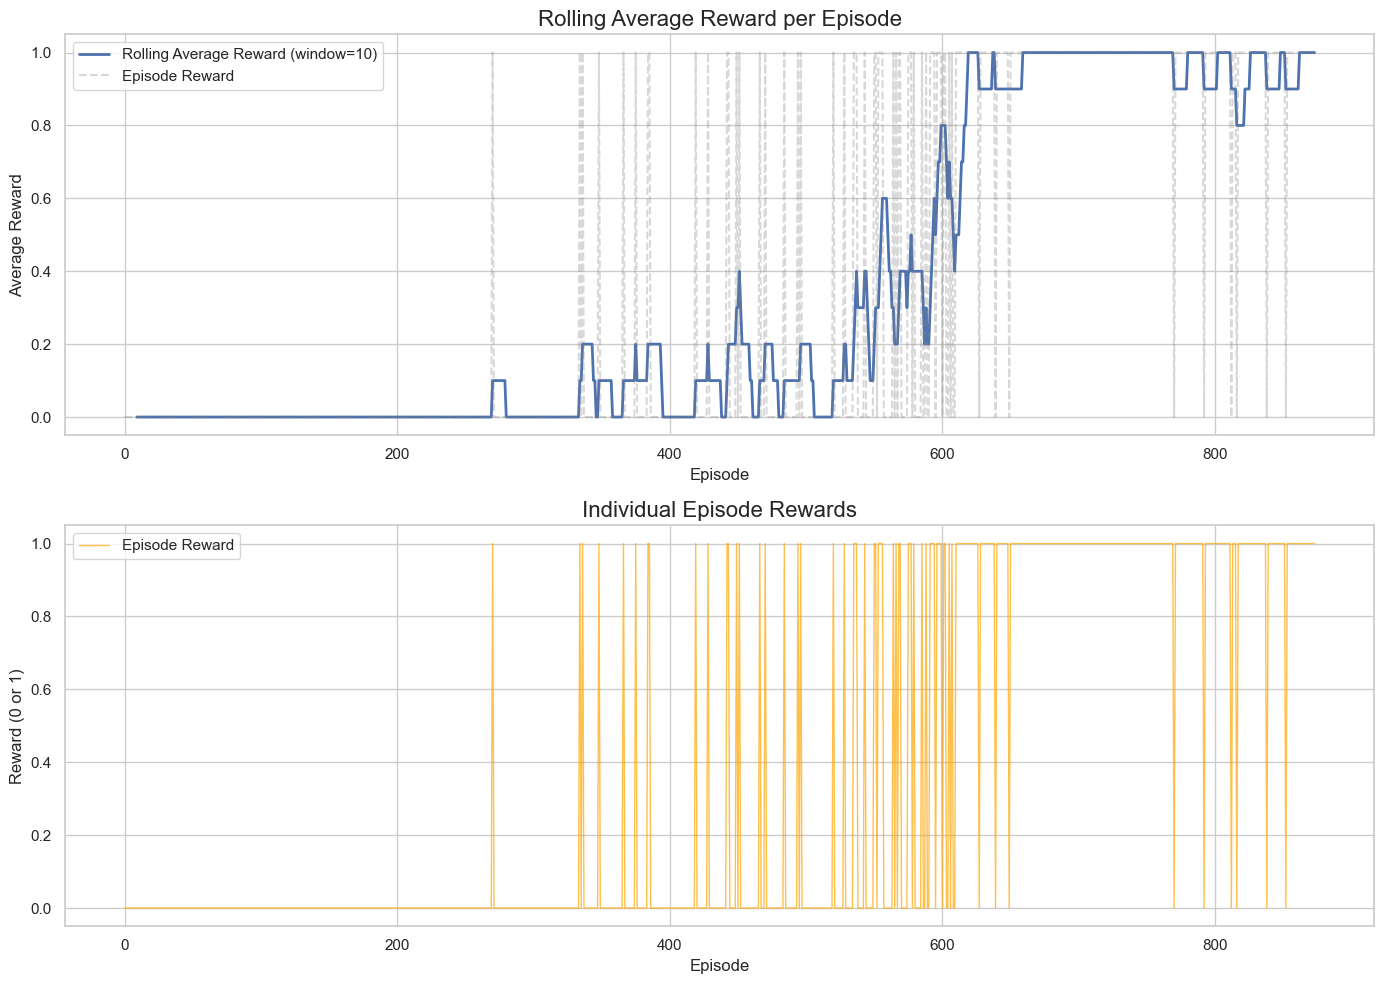

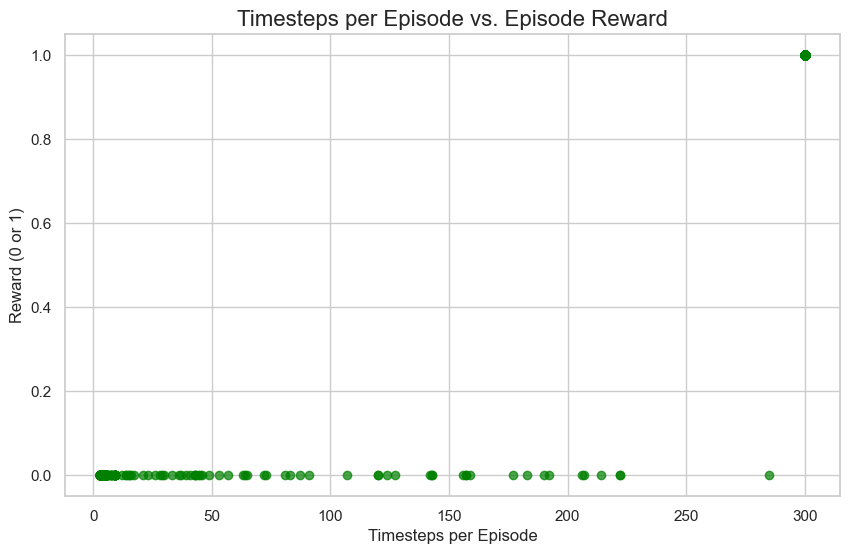

In [9]:
# Set style for seaborn
sns.set(style="whitegrid")

# Load the training data from the monitor.csv file
file_path = './logs_without_rm/monitor.csv'
df = pd.read_csv(file_path, skiprows=1)

# Extract the necessary columns
episode_rewards = df['r']  # Rewards
episode_lengths = df['l']  # Episode lengths (timesteps per episode)
timesteps = df['t']        # Time elapsed for each episode 

# Parameters for rolling window
rolling_window_size = 10  
rolling_rewards = episode_rewards.rolling(window=rolling_window_size).mean()

plt.figure(figsize=(14, 10))

# Plot 1: Rolling Average Reward per Episode
plt.subplot(2, 1, 1)
plt.plot(rolling_rewards, label=f'Rolling Average Reward (window={rolling_window_size})', color='b', linewidth=2)
plt.plot(episode_rewards, label='Episode Reward', alpha=0.3, linestyle='--', color='gray')
plt.title('Rolling Average Reward per Episode', fontsize=16)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.grid(True)
plt.legend(loc='upper left')

# Plot 2: Individual Episode Rewards (0 or 1)
plt.subplot(2, 1, 2)
plt.plot(episode_rewards, label='Episode Reward', alpha=0.7, color='orange', linewidth=1)
plt.title('Individual Episode Rewards', fontsize=16)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Reward (0 or 1)', fontsize=12)
plt.grid(True)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

'''
# Plot 3: Reward Distribution Histogram
plt.figure(figsize=(8, 5))
plt.hist(episode_rewards, bins=2, edgecolor='black', alpha=0.7, color='purple')
plt.title('Reward Distribution (0 vs 1)', fontsize=16)
plt.xlabel('Reward', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()
'''

# Plot 4: Timesteps per Episode vs. Episode Reward
plt.figure(figsize=(10, 6))
plt.scatter(episode_lengths, episode_rewards, alpha=0.7, color='green')
plt.title('Timesteps per Episode vs. Episode Reward', fontsize=16)
plt.xlabel('Timesteps per Episode', fontsize=12)
plt.ylabel('Reward (0 or 1)', fontsize=12)
plt.grid(True)
plt.show()


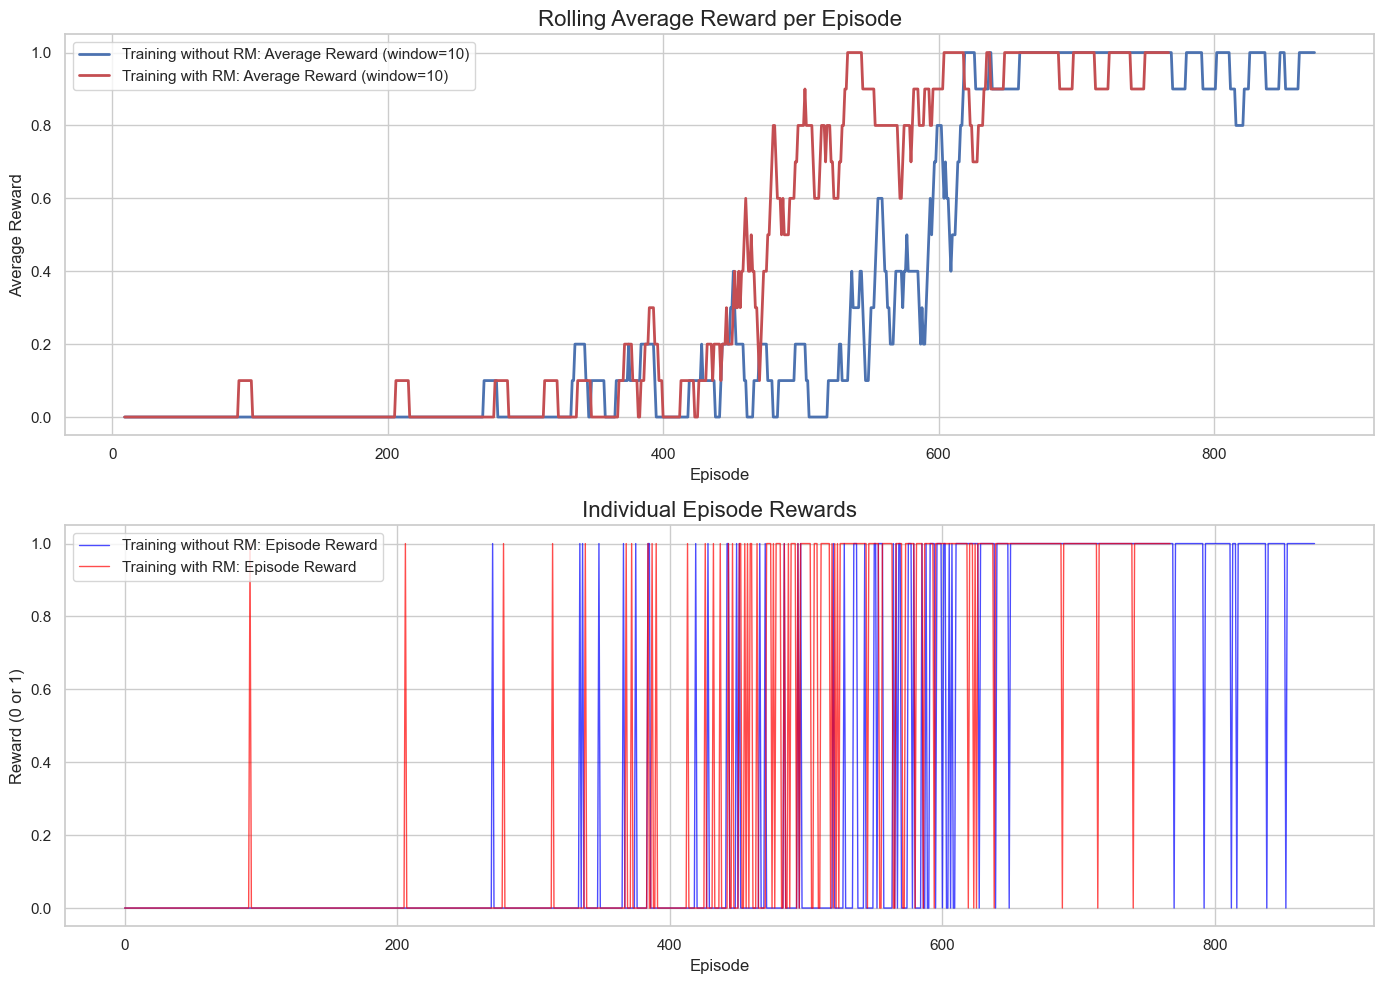

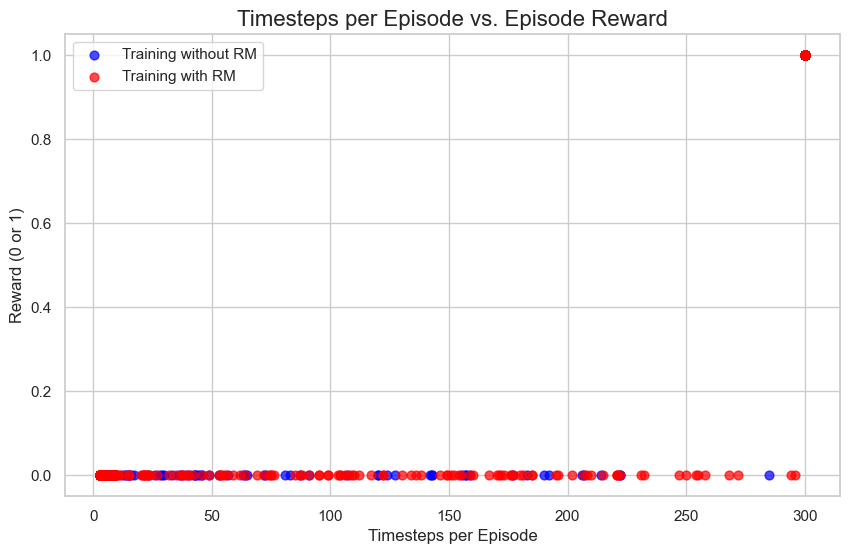

In [7]:
# Set style for seaborn
sns.set(style="whitegrid")

# Load the data from the two CSV files
file_path_1 = './logs_without_rm/monitor.csv'  # First training log
file_path_2 = './logs_with_rm/monitor.csv'  # Second training log

df1 = pd.read_csv(file_path_1, skiprows=1)
df2 = pd.read_csv(file_path_2, skiprows=1)

# Extract the necessary columns for both trainings
episode_rewards_1 = df1['r']  # Rewards for first training
episode_lengths_1 = df1['l']  # Episode lengths for first training
timesteps_1 = df1['t']        # Time elapsed for each episode 

episode_rewards_2 = df2['r']  # Rewards for second training
episode_lengths_2 = df2['l']  # Episode lengths for second training
timesteps_2 = df2['t']        # Time elapsed for each episode 

# Parameters for rolling window
rolling_window_size = 10  # Adjust the window size for smoothing
rolling_rewards_1 = episode_rewards_1.rolling(window=rolling_window_size).mean()
rolling_rewards_2 = episode_rewards_2.rolling(window=rolling_window_size).mean()

plt.figure(figsize=(14, 10))

# Plot 1: Rolling Average Reward per Episode for both trainings
plt.subplot(2, 1, 1)
plt.plot(rolling_rewards_1, label=f'Training without RM: Average Reward (window={rolling_window_size})', color='b', linewidth=2)
plt.plot(rolling_rewards_2, label=f'Training with RM: Average Reward (window={rolling_window_size})', color='r', linewidth=2)
plt.title('Rolling Average Reward per Episode', fontsize=16)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.grid(True)
plt.legend(loc='upper left')

# Plot 2: Individual Episode Rewards for both trainings
plt.subplot(2, 1, 2)
plt.plot(episode_rewards_1, label='Training without RM: Episode Reward', alpha=0.7, color='blue', linewidth=1)
plt.plot(episode_rewards_2, label='Training with RM: Episode Reward', alpha=0.7, color='red', linewidth=1)
plt.title('Individual Episode Rewards', fontsize=16)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Reward (0 or 1)', fontsize=12)
plt.grid(True)
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Plot 3: Timesteps per Episode vs. Episode Reward (both trainings)
plt.figure(figsize=(10, 6))
plt.scatter(episode_lengths_1, episode_rewards_1, alpha=0.7, color='blue', label='Training without RM', s=40)
plt.scatter(episode_lengths_2, episode_rewards_2, alpha=0.7, color='red', label='Training with RM', s=40)
plt.title('Timesteps per Episode vs. Episode Reward', fontsize=16)
plt.xlabel('Timesteps per Episode', fontsize=12)
plt.ylabel('Reward (0 or 1)', fontsize=12)
plt.grid(True)
plt.legend()
plt.show()
